This notebook trains a CNN to classify male vs female flies from a ventral view. Future work will address their dorsal profile.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from keras.models       import Sequential, load_model
from keras.layers       import Dense, Dropout, Activation, Flatten
from keras.layers       import Conv2D, MaxPooling2D
from keras.utils        import np_utils
from keras.datasets     import mnist
from keras.optimizers   import Adam, Nadam
from keras.callbacks    import ModelCheckpoint, History

Using TensorFlow backend.


## Load Data

In [2]:
print('Loading...')
mvent = np.load('ndarrays/mvent.npy')
fvent = np.load('ndarrays/fvent.npy')
print('Availible male samples:'  , len(mvent))
print('Availible female samples:', len(fvent))
print('Load Complete')

Loading...
Availible male samples: 3908
Availible female samples: 5178
Load Complete


## Preprocessing

First, to keep things simple I want an equal number of males and females

In [3]:
minlen = min(len(mvent), len(fvent))
mvent  = mvent[:minlen]
fvent  = fvent[:minlen]
flies  = np.concatenate((mvent, fvent))
flies  = flies.reshape(flies.shape[0], *flies.shape[2:], flies.shape[1])

Now I'll create their corresponding labels. Note, since we only have two classes we do not need to make binary matrices.

In [4]:
labels = np.zeros(len(flies))
labels[minlen:] += 1 # males == 0, females == 1

Shuffling the flies and labels together, now, will avoid repeating code later

In [5]:
i_shuffled = np.random.permutation(len(labels))
labels = labels[i_shuffled]
flies  = flies [i_shuffled]

If we take a peak at a few flies we can gather a little peace of mind--  the flies are correctly labeled.

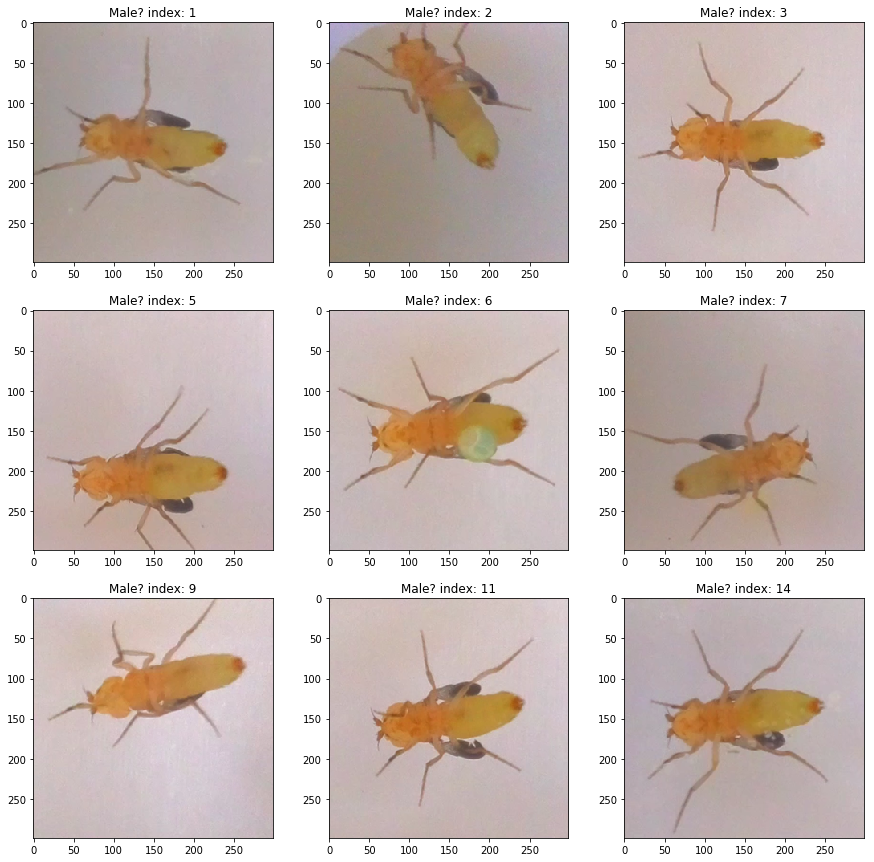

In [6]:
fig = plt.figure(figsize=(15,15))
males_found = 0
for i, (label, fly) in enumerate(zip(labels, flies)):
    if label == 0:
        fig.add_subplot(3,3,males_found+1) 
        plt.imshow(fly)
        plt.title('Male? index: ' + str(i))
        males_found += 1
    if males_found == 9: break

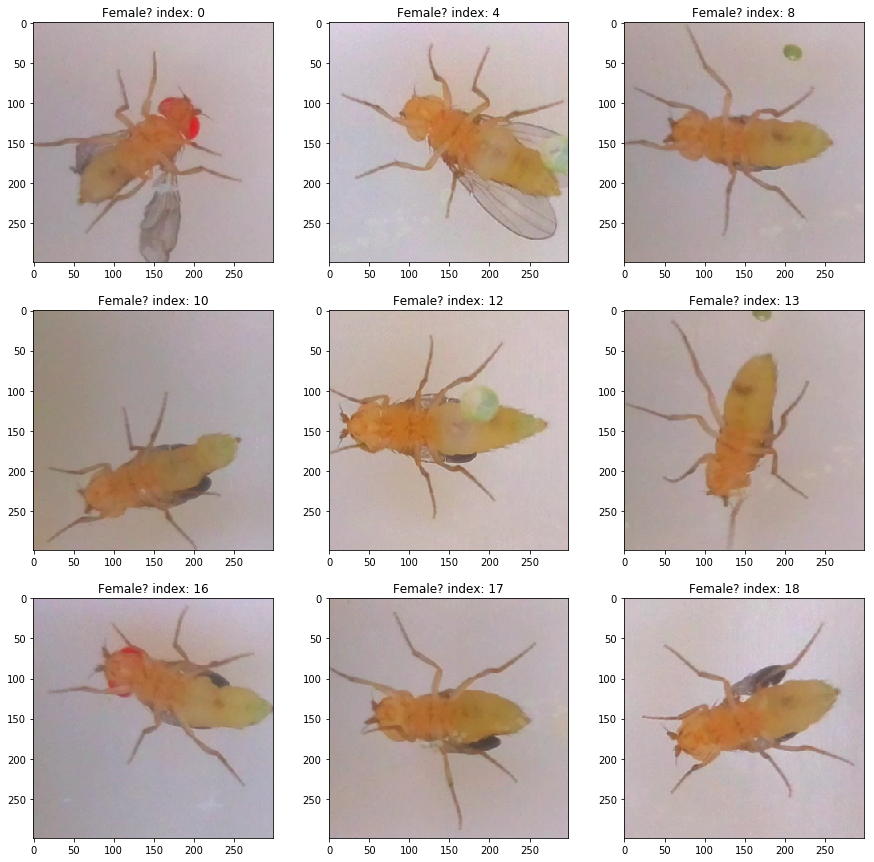

In [22]:
fig = plt.figure(figsize=(15,15))
females_found = 0
for i, (label, fly) in enumerate(zip(labels, flies)):
    if label == 1:
        fig.add_subplot(3,3, females_found+1) 
        plt.imshow(fly)
        plt.title('Female? index: ' + str(i))
        females_found += 1
    if females_found == 9: break

The males look male and the females look female, so let's split them into training, validation, and test sets.

## Normalization

In [8]:
flies  = flies.astype(np.float32)
flies /= 255

In [9]:
f_train = 0.8 # Let's train on 80% and validate/test on 10% each

In [10]:
len_train = int(np.floor(len(flies) * f_train))
len_valid = (len(flies) - len_train) // 2
len_test  = len(flies) - len_train - len_valid
x_train = flies [:len_train]
y_train = labels[:len_train]
x_valid = flies [len_train: -len_test]
y_valid = labels[len_train: -len_test]
x_test  = flies [-len_test:]
y_test  = labels[-len_test:]
print('Training set samples  :', len(x_train), 'and labels:', len(y_train))
print('Validation set samples:', len(x_valid), ' and labels:', len(y_valid))
print('Test set samples      :', len(x_test) , ' and labels:', len(y_test))

Training set samples  : 6252 and labels: 6252
Validation set samples: 782  and labels: 782
Test set samples      : 782  and labels: 782


Check that the number of males and females in each set are roughly equal

In [11]:
print('Percent female in... ')
print('training set  : ' + str(y_train.sum() / len(y_train) * 100) + '%')
print('validation set: ' + str(y_valid.sum() / len(y_valid) * 100) + '%')
print('test set      : ' + str(y_test .sum() / len(y_test ) * 100) + '%')

Percent female in... 
training set  : 50.2079334613%
validation set: 48.8491048593%
test set      : 49.4884910486%


Build Neural Net

In [12]:
w_init = 'glorot_normal' # Weights initialization
opt = Nadam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.01)
model = Sequential()
model.add(MaxPooling2D(pool_size=(2, 2), input_shape=(299, 299, 3)))
model.add(Conv2D(8, (4, 4), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu',kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (2, 2), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (2, 2), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu', kernel_initializer=w_init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=w_init))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 8)       392       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 32)        0         
__________

In [13]:
callbacks = [ModelCheckpoint('models/v_weights000.hdf5')]
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=15, 
                    verbose=1, 
                    validation_data=(x_valid, y_valid), 
                    callbacks=callbacks)

Train on 6252 samples, validate on 782 samples
Epoch 1/15
6252/6252 [==============================] - 177s 28ms/step - loss: 0.6804 - acc: 0.5685 - val_loss: 0.5504 - val_acc: 0.7698
Epoch 2/15
6252/6252 [==============================] - 167s 27ms/step - loss: 0.2782 - acc: 0.8808 - val_loss: 0.0897 - val_acc: 0.9629
Epoch 3/15
6252/6252 [==============================] - 161s 26ms/step - loss: 0.0799 - acc: 0.9712 - val_loss: 0.0265 - val_acc: 0.9936
Epoch 4/15
6252/6252 [==============================] - 168s 27ms/step - loss: 0.0377 - acc: 0.9886 - val_loss: 0.0145 - val_acc: 0.9949
Epoch 5/15
6252/6252 [==============================] - 176s 28ms/step - loss: 0.0258 - acc: 0.9926 - val_loss: 0.0054 - val_acc: 0.9987
Epoch 6/15
6252/6252 [==============================] - 172s 27ms/step - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0091 - val_acc: 0.9962
Epoch 7/15
6252/6252 [==============================] - 168s 27ms/step - loss: 0.0077 - acc: 0.9978 - val_loss: 0.0080 - val_acc: 0

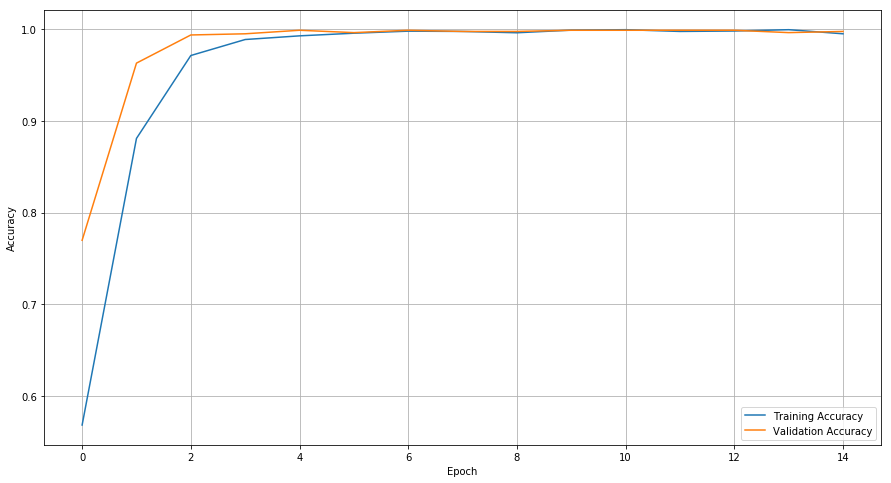

In [21]:
plt.figure(figsize=(15,8))
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Load model with best validation accuracy

In [15]:
model = load_model('models/v_weights000.hdf5')

In [18]:
_, acc = model.evaluate(x_test, y_test)

782/782 [==============================] - 7s 9ms/step


In [20]:
print('Test accuracy: ' + str(acc*100) + '%')

Test accuracy: 99.7442455243%
